In [1]:
import os


data_root = "/data/shared/rccars/"
mmdet_root = "../third_party/avstack-core/third_party/mmdetection"

### Analyze the performance of the models vs epoch

In [37]:
from avapi.rccars import RcCarsScenesManager

scene_manager = RcCarsScenesManager(data_dir="/data/shared/rccars")
print(f"Available scenes: {scene_manager.scenes}")

Available scenes: ['old', 'oneclass-detection-2024', 'oneclass-detection-2025', 'raw-2024', 'raw-2025']


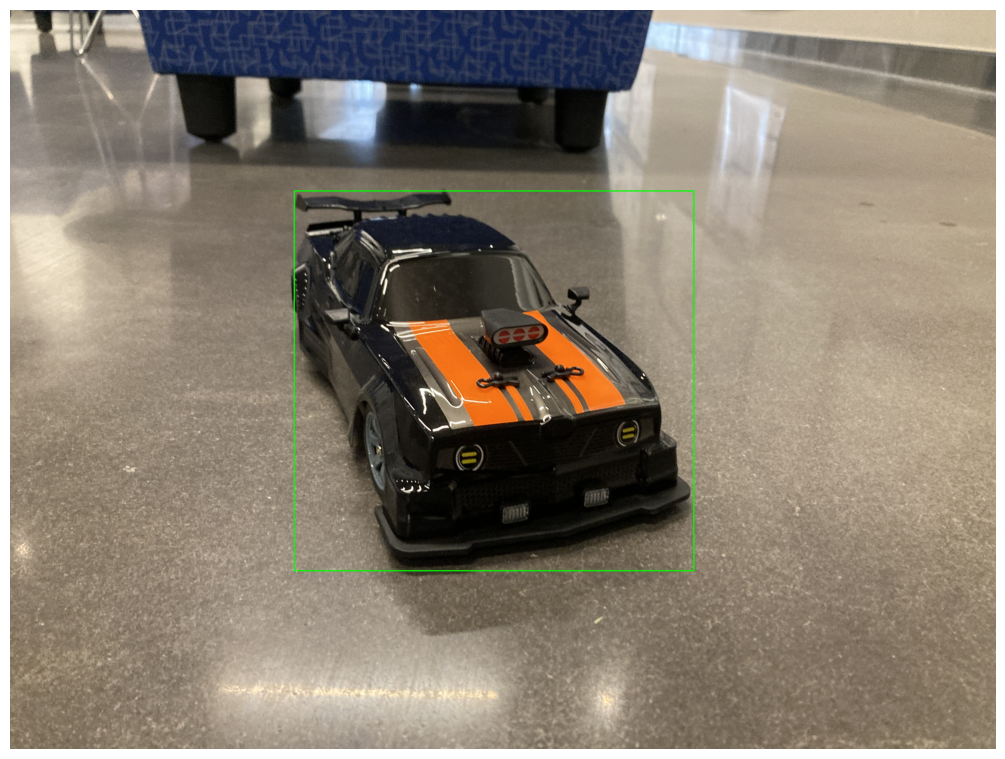

In [55]:
from avapi.visualize.snapshot import show_image_with_boxes


frame = 10
scene_dataset = scene_manager.get_scene_dataset_by_name("oneclass-detection-2024", "train")
img = scene_dataset.get_image(frame=frame)
boxes = scene_dataset.get_boxes(frame=frame, sensor="camera")
show_image_with_boxes(img=img, boxes=boxes, inline=True, show=True)

In [101]:
import numpy as np
from avstack.modules.assignment import build_A_from_iou, gnn_single_frame_assign
from avstack.modules.perception.object2dfv import MMDetObjectDetector2D


def compute_metrics(objs_det, objs_tru):
    # compute metrics
    # -- perform assignment
    A_assign = build_A_from_iou(objs_det, objs_tru)
    assigns = gnn_single_frame_assign(A_assign)

    # -- report fp/rn rate
    n_fp = len(assigns.unassigned_rows)
    n_fn = len(assigns.unassigned_cols)
    print(f"{assigns.nrow} detected\n---------------------")
    print(f"{assigns.nrow - n_fp} assignment")
    print(f"{n_fp} false positives ({100*n_fp/assigns.nrow:.2f}% of detections)")
    print(f"{n_fn} false negatives ({100*n_fn/assigns.ncol:.2f}% of truths)")

    # -- report average IoU of matches
    ious = [objs_det[a[0]].IoU(objs_tru[a[1]]) for a in assigns.assignment_tuples]
    print(f"Matches had IoU of: [{', '.join(map(str, ious))}] each")
    print(f"Mean IoU: {np.mean(ious):.2f}")

    return assigns, n_fp, n_fn, ious


def load_model(epoch: int, threshold: float):
    # set up this model
    detector = MMDetObjectDetector2D(
        model="rtmdet",
        dataset="rccars-oneclass",
        deploy=False,
        threshold=threshold,
        gpu=0,
        epoch=epoch,
    )
    return detector

In [95]:

# the set of available epochs is in:
# /home/cpsl-interns/Documents/cpsl-label-studio/model-training/third_party/avstack-core/third_party/mmdetection/work_dirs/rtmdet_m_8xb32-300e_rccars-oneclass
epoch = 10
threshold = 0.1  # between [0, 1]
detector = load_model(epoch=epoch, threshold=threshold)

Overriding default threshold of 0.5 with 0.1
Loads checkpoint by local backend from path: /home/cpsl-interns/Documents/cpsl-label-studio/model-training/third_party/avstack-core/third_party/mmdetection/work_dirs/rtmdet_m_8xb32-300e_rccars-oneclass/epoch_10.pth


In [102]:
# test the model on some examples from train and val
frame = 0
img = scene_dataset.get_image(frame=frame)
objs_det = detector(img)

# metrics
objs_tru = scene_dataset.get_boxes(frame=frame, sensor="camera")
assigns, n_fp, n_fn, ious = compute_metrics(objs_det, objs_tru)

3 detected
---------------------
1 assignment
2 false positives (66.67% of detections)
0 false negatives (0.00% of truths)
Matches had IoU of: [0.530713521989238] each
Mean IoU: 0.53


/home/cpsl-interns/Documents/cpsl-label-studio/model-training/third_party/avstack-core/avstack/calibration.py:189: RuntimeWarning: invalid value encountered in scalar divide
  self.b_x = self.P[0, 3] / (-self.f_u)  # relative
/home/cpsl-interns/Documents/cpsl-label-studio/model-training/third_party/avstack-core/avstack/calibration.py:190: RuntimeWarning: invalid value encountered in scalar divide
  self.b_y = self.P[1, 3] / (-self.f_v)


False

DETECTED


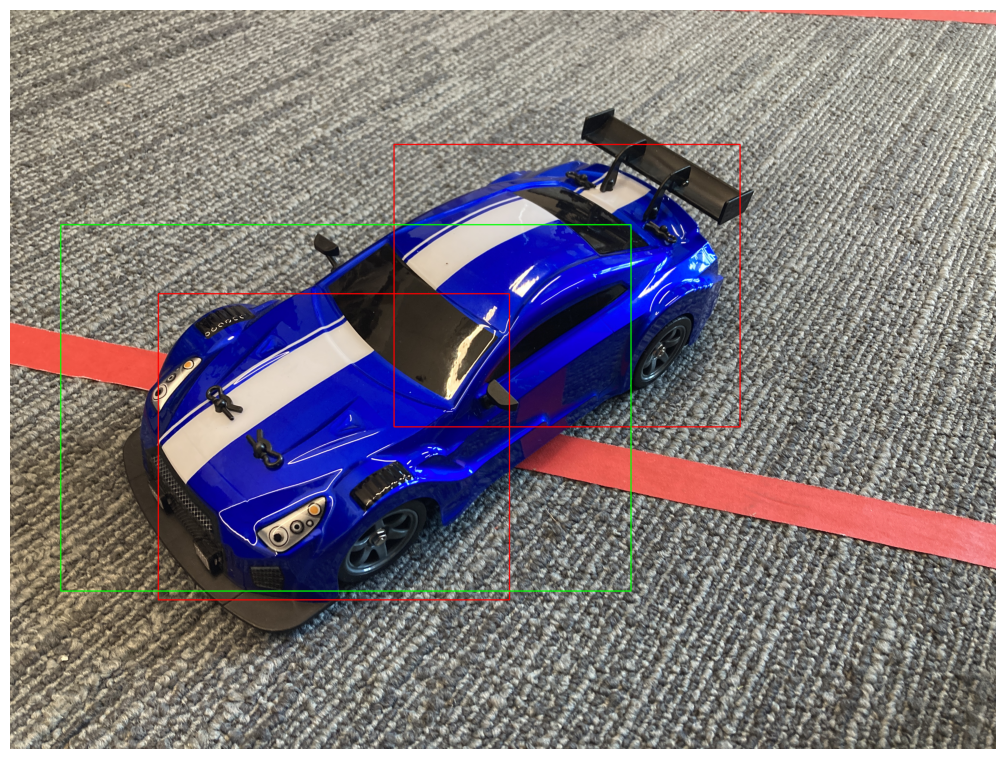

GROUND TRUTH


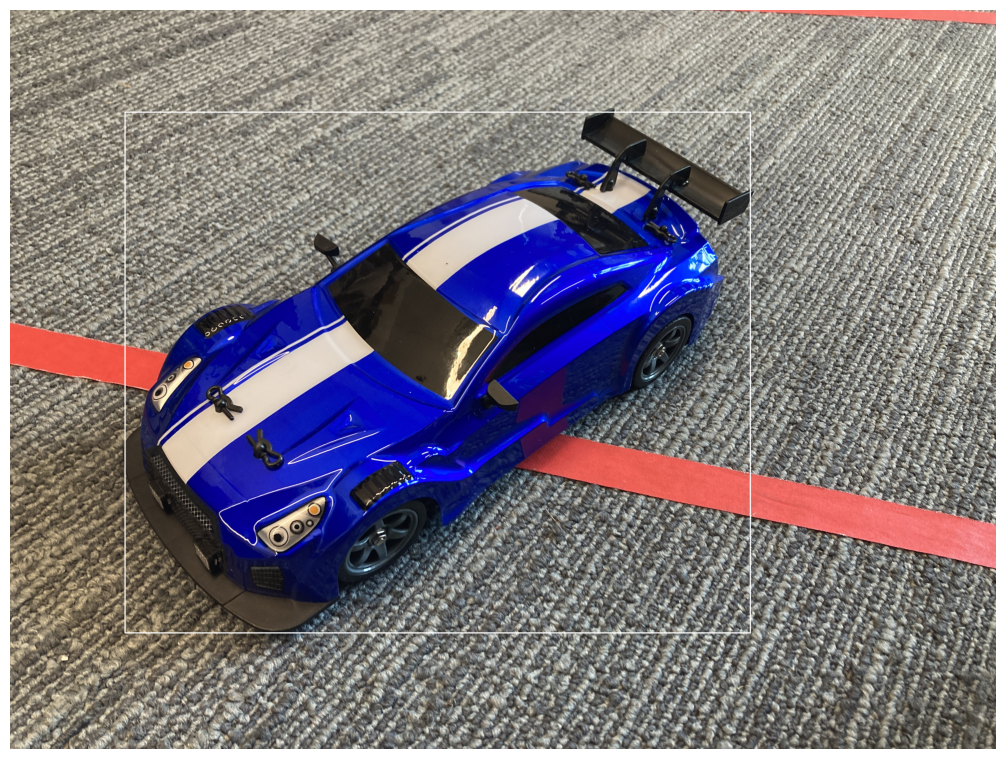

In [108]:
# visualize the detected
print("DETECTED")
det_colors = [
    "green" if assigns.has_assign(row=i) else "red"
    for i in range(len(objs_det))
]
show_image_with_boxes(
    img=img,
    boxes=objs_det,
    box_colors=det_colors,
    inline=True,
    show=True,
)

# visualize the truth
print("GROUND TRUTH")
show_image_with_boxes(
    img=img,
    boxes=objs_tru,
    box_colors="white",
    inline=True,
    show=True,
)